# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment.

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables.

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder.

In [1]:
#######################
#############
##############################

import re
import torch
from typing import Any, List, Optional, Union


# CUDA setup
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(f'Using {DEVICE}')



########## YOUR SOLUTION HERE ##########
class Encoder:
    def __init__(
        self, alphabet: str = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
    ) -> None:
        self.pattern = re.compile(r"[^a-z0-9 .!?]*")
        alphabet = self.pattern.sub("", alphabet.lower())
        self.alphabet = sorted(list(set([*alphabet])))

    def __call__(self, arg: str | torch.Tensor) -> torch.Tensor | str:
        if isinstance(arg, str):
            arg = self.pattern.sub("", arg)
            return torch.tensor(
                [self.alphabet.index(c) for c in [*arg] if c in self.alphabet],
                dtype=torch.int32,
            ).to(DEVICE)
        elif isinstance(arg, torch.Tensor):
            # catch scalars
            if arg.ndim == 0:
                arg = torch.tensor([arg.item()])

            return "".join(
                [self.alphabet[c] for c in arg.cpu().numpy() if c < len(self.alphabet)]
            )
        else:
            raise TypeError("arg must be string or torch.Tensor")

    def __print__(self):
        for idx, c in enumerate(self.alphabet):
            print(f"({idx}) {c}")


encoder = Encoder()

# Print the length of the alphabet
print(len(encoder.alphabet))

# Test encoding and decoding
print(encoder("hello lstm!"))
print(encoder(torch.tensor([21, 18, 25, 25, 28,  0, 25, 32, 33, 26,  1])))

Using cpu
40
tensor([21, 18, 25, 25, 28,  0, 25, 32, 33, 26,  1], dtype=torch.int32)
hello lstm!


## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped.

In [57]:
import torch
from torch.utils.data import Dataset
from pathlib import Path

########## YOUR SOLUTION HERE ##########

class TextDataset(Dataset):
    def __init__(self, path: str, sequence_length: int):
        """
        Initialize a TextDataset.

        Args:
            path (str): Path to the text file.
            sequence_length (int): Length of each sequence.
        """
        super().__init__()

        # Create an instance of the Encoder class
        self.encoder = Encoder()

        # Check if the file exists
        self.file = Path(path)
        if not self.file.exists():
            raise ValueError(f"Invalid path {self.file} (file doesn't exist)")

        # Read the text file and convert it to lowercase
        with open(self.file, "r", encoding="utf8") as f:
            seq = f.read().lower()

        # Encode the text sequence using the encoder
        tensor = self.encoder(seq)
        assert isinstance(tensor, torch.Tensor)

        # Calculate the number of sequences based on the sequence length
        length = tensor.shape[0] // sequence_length

        # Reshape the tensor into sequences of the specified length
        self.sequences = tensor[:length * sequence_length].reshape(length, sequence_length).to(DEVICE)

        self.sequence_length = sequence_length

    def __len__(self):
        """
        Get the number of sequences in the dataset.

        Returns:
            int: Number of sequences.
        """
        return self.sequences.shape[0]

    def __getitem__(self, idx: int):
        """
        Get a sequence at the specified index.

        Args:
            idx (int): Index of the sequence.

        Returns:
            torch.Tensor: Sequence tensor.
        """
        assert idx < self.sequences.shape[0]  # Check out of bounds
        return self.sequences[idx, :]

    def __getitem_as_text__(self, idx: int):
        """
        Get a sequence as text at the specified index.

        Args:
            idx (int): Index of the sequence.

        Returns:
            str: Decoded sequence as text.
        """
        assert idx < self.sequences.shape[0]  # Check out of bounds

        # Decode the sequence using the encoder
        out_decoded = self.encoder(self.sequences[idx, :])
        assert isinstance(out_decoded, str)  # Typing

        return out_decoded

## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step.

In [58]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########

class NextCharLSTM(nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, hidden_dim: int):
        """
        Initialize the NextCharLSTM module.

        Args:
            alphabet_size (int): Size of the alphabet.
            embedding_dim (int): Dimensionality of the embeddings.
            hidden_dim (int): Dimensionality of the hidden states.
        """
        super().__init__()

        self.alphabet_size = alphabet_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Map the alphabet to embeddings
        self.embeddings = nn.Embedding(num_embeddings=alphabet_size, embedding_dim=embedding_dim)

        # LSTM layer takes embeddings as inputs and maps to hidden states
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        # Output layer that maps hidden states of LSTM back to the alphabet
        self.out = nn.Linear(in_features=hidden_dim, out_features=alphabet_size)

    def forward(self, sequences):
        """
        Forward pass of the NextCharLSTM module.

        Args:
            sequences (torch.Tensor): Input sequences.

        Returns:
            torch.Tensor: Logits for each character in the sequences.
        """
        batch_size, seq_size = sequences.shape

        # Initialize the initial hidden and cell states
        h_0 = nn.Parameter(torch.randn(1, batch_size, self.hidden_dim), requires_grad=True).to(DEVICE)
        c_0 = nn.Parameter(torch.randn(1, batch_size, self.hidden_dim), requires_grad=True).to(DEVICE)

        # Embed the input sequences
        embeddings = self.embeddings(sequences)

        # Pass the embeddings through the LSTM layer
        lstm_output, _ = self.lstm(embeddings, (h_0, c_0))

        # Flatten the LSTM output and pass it through the output layer
        logits = self.out(lstm_output.reshape(batch_size * seq_size, -1))

        return logits

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation.

In [59]:
from torch.utils.data import DataLoader
from torch.optim.optimizer import Optimizer
import numpy as np
import numpy.typing as npt


########## YOUR SOLUTION HERE ##########
def epoch(
    loader: DataLoader, model: NextCharLSTM, optimizer: Optional[Optimizer] = None):
    losses: npt.NDArray = np.zeros(len(loader))
    loss_f = nn.CrossEntropyLoss()

    # Default 1, as per PyTorch documentation.
    batch_size = loader.batch_size if loader.batch_size else 1

    # Parts of code taken from PyTorch documentation
    #   Tutorials > Sequence Models and Long Short-Term Memory Networks
    for i, x in enumerate(loader):
        seq_size = x.shape[1] - 1

        if optimizer:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

        # Step 2. Get our target values.
        target = x[:, 1:].type(torch.LongTensor).to(DEVICE)

        # Step 3. Run our forward pass.
        pred = model(x[:, :-1]).to(DEVICE)

        # Step 4. Compute the loss.
        loss = loss_f(
            pred.view(batch_size * seq_size, -1), target.view(batch_size * seq_size)
        )

        if optimizer:
            # Step 5. Compute the gradients and update the parameters by
            # calling optimizer.step()
            loss.backward()

            optimizer.step()

        losses[i] = loss.item()
        cost =np.mean(losses)

    return cost

## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress.

Loss: Training 3.08323, Validation: 2.88728 (epoch 1)
Loss: Training 1.95604, Validation: 2.09833 (epoch 10)
Loss: Training 1.47721, Validation: 1.70553 (epoch 20)
Loss: Training 1.26895, Validation: 1.56241 (epoch 30)
Loss: Training 1.14904, Validation: 1.51981 (epoch 40)
Loss: Training 1.06496, Validation: 1.52249 (epoch 50)
Loss: Training 0.98876, Validation: 1.54895 (epoch 60)
Loss: Training 0.93025, Validation: 1.59607 (epoch 70)
Loss: Training 0.88091, Validation: 1.64125 (epoch 80)
Loss: Training 0.83824, Validation: 1.71242 (epoch 90)
Loss: Training 0.79228, Validation: 1.74870 (epoch 100)
Saved model with best validation loss 1.51485 from epoch 44


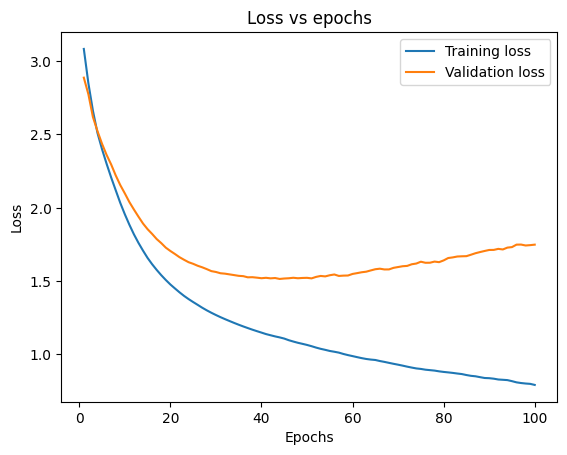

In [60]:
##########
##################
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 100

########## YOUR SOLUTION HERE ##########
# 1. Alphabet & Encoder
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
encoder = Encoder(alphabet)

# 2. Datasets
train_data = TextDataset("/content/trump_train.txt", sequence_length)
valid_data = TextDataset("/content/trump_val (1).txt", sequence_length)

train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(
    valid_data, batch_size=int(batch_size / 2), drop_last=True
)

# 3. Model
model = NextCharLSTM(
    alphabet_size=len(encoder.alphabet),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
).to(DEVICE)

# 4. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 5. Training, validation
epochs = np.arange(1, num_epochs + 1)
training_loss, validation_loss = [], []
best_loss = np.Infinity
best_epoch = 1
#save_path = Path("./model.pt")
save_path ='/content/model_n1.pt'

for e in epochs:
    t_loss = epoch(train_dataloader, model, optimizer)
    v_loss = epoch(valid_dataloader, model, optimizer=None)

    training_loss.append(t_loss)
    validation_loss.append(v_loss)

    if v_loss < best_loss:
        torch.save(model, save_path)
        best_loss = v_loss
        best_epoch = e

    if e == 1 or e % 10 == 0:
        print(f"Loss: Training {t_loss:.5f}, Validation: {v_loss:.5f} (epoch {e})")

print(f"Saved model with best validation loss {best_loss:.5f} from epoch {best_epoch}")


# Plot
fig, ax = plt.subplots()

ax.plot(epochs, training_loss, label="Training loss")
ax.plot(epochs, validation_loss, label="Validation loss")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs epochs")

plt.legend()
plt.show()

## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results.

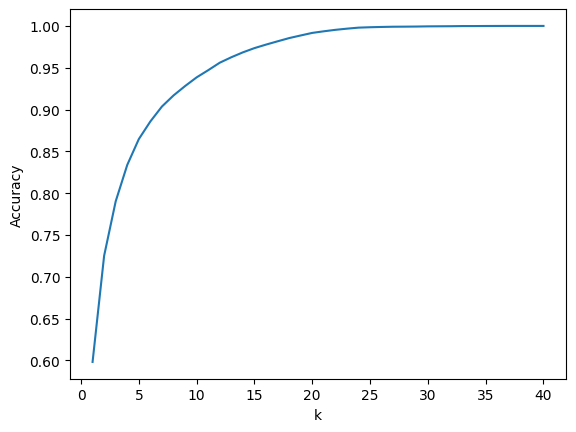

In [61]:
########## YOUR SOLUTION HERE ##########
def topk_accuracy(k: List[int], model: NextCharLSTM, loader: DataLoader) -> npt.NDArray:
    # k_accs: List = []
    k_accs: npt.NDArray = np.zeros((len(k), len(loader)))

    # iterate over batches
    for i, x in enumerate(loader):
        with torch.no_grad():
            # get target and prediction
            target = x[:, 1:][0].type(torch.LongTensor).to(DEVICE)
            pred = model(x[:, :-1]).to(DEVICE)

            # iterate over k
            for _k in k:
                # get indices of the top k
                topk_indices = torch.topk(pred, _k + 1).indices
                k_zeros = torch.subtract(topk_indices.T.to(DEVICE), target)

                # compute accuracy
                acc = torch.count_nonzero(k_zeros == 0) / k_zeros.shape[1]

                k_accs[_k][i] = acc.item()

    # return mean accuracy of a batch for every k
    return np.mean(k_accs, axis=1)


k = list(range(40))
model = torch.load(Path("/content/model_n1.pt"))
valid_dataloader = DataLoader(valid_data, shuffle=True, batch_size=1, drop_last=True)

topk_acc = topk_accuracy(k, model, valid_dataloader)

# Plot
fig, ax = plt.subplots()

ax.plot(np.arange(1, 41), topk_acc)

ax.set_xlabel("k")
ax.set_ylabel("Accuracy")

plt.show()

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size.

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k)
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best.

In [62]:
########## YOUR SOLUTION HERE ##########
from torch.distributions import Gumbel


def gumbel_max_sample(x: torch.Tensor):
    g = Gumbel(0, 1)
    z = g.sample(x.shape)

    assert isinstance(z, torch.Tensor)  # typing

    return (x + z.to(DEVICE)).argmax()


def gumbel_max_sampling(
    seed: str, temp: float, model: NextCharLSTM, encoder: Encoder, length: int = 50):
    cur_input = encoder(seed)
    result = seed

    for i in range(length):
        assert isinstance(cur_input, torch.Tensor)
        cur_input = cur_input[None, :]
        pred = model(cur_input).to(DEVICE)

        gumbel = pred[-1, :] / temp
        chosen_pred = gumbel_max_sample(gumbel)

        result += encoder(chosen_pred)
        cur_input = encoder(result[i:])

        print(result)


gumbel_max_sampling("It's known that,Lstm is  ", 0.1, model,encoder,50)

It's known that,Lstm is  i
It's known that,Lstm is  in
It's known that,Lstm is  in 
It's known that,Lstm is  in t
It's known that,Lstm is  in th
It's known that,Lstm is  in the
It's known that,Lstm is  in the 
It's known that,Lstm is  in the w
It's known that,Lstm is  in the wo
It's known that,Lstm is  in the wor
It's known that,Lstm is  in the worl
It's known that,Lstm is  in the world
It's known that,Lstm is  in the world 
It's known that,Lstm is  in the world t
It's known that,Lstm is  in the world th
It's known that,Lstm is  in the world tha
It's known that,Lstm is  in the world that
It's known that,Lstm is  in the world that 
It's known that,Lstm is  in the world that w
It's known that,Lstm is  in the world that we
It's known that,Lstm is  in the world that we 
It's known that,Lstm is  in the world that we h
It's known that,Lstm is  in the world that we ha
It's known that,Lstm is  in the world that we hav
It's known that,Lstm is  in the world that we have
It's known that,Lstm is  

## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers.

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set.
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature?

In [63]:
##############
from heapq import heapify, heappop, heappush
from tqdm import tqdm


def huffman_code(freqs):
    """This function turns a list of frequencies into a Huffman code."""
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [""] * len(freqs)

    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))

        for i in idx0:
            code[i] = "0" + code[i]

        for i in idx1:
            code[i] = "1" + code[i]

    return code


########## YOUR SOLUTION HERE ##########
from collections import Counter


def calculate_average_code_length(data, model, ecnoder, temp=1.0):
    total_code_length = 0
    num_symbols = 0

    for i in range(len(data)):
        # Encode the current symbol
        symbol = data[i]
        symbol_tensor = encoder(symbol).unsqueeze(0)

        # Use the model to predict the next symbol
        next_symbol_logits = model(symbol_tensor)

        # Apply softmax with temperature
        next_symbol_probs = torch.softmax(next_symbol_logits / temp, dim=1)

        # Calculate the frequencies based on the prediction probabilities
        #   1 / temperature, which scales down the prediction probabilities
        #   helps generate more diverse and less predictable text
        #   when sampling from the distribution
        freqs = next_symbol_probs[0].detach().cpu().numpy() ** (1 / temp)
        freqs /= freqs.sum()
        freqs = freqs.squeeze()

        # Construct a Huffman code using the frequencies
        huffman_code_res = huffman_code(list(freqs))
        symbol_code_map = {
            next_symbol: code
            for next_symbol, code in zip(encoder.alphabet, huffman_code_res)
        }

        # Add the code length to the total
        total_code_length += len(symbol_code_map[symbol])
        num_symbols += 1

    # Calculate the average code length per symbol
    return total_code_length / num_symbols


# Load the encoder
encoder = Encoder()

train_data = [
    char for batch in train_dataloader for seq in batch for char in encoder(seq)
]
valid_data = [
    char for batch in valid_dataloader for seq in batch for char in encoder(seq)
]

# number of occurences of each symbol in the training set
symbol_counts = Counter(train_data)

# frequences of each symbol based on the number of occurences
symbol_frequencies = [count / len(train_data) for count in symbol_counts.values()]

# Huffman code based on the symbol ferquencies
symbol_codes = huffman_code(symbol_frequencies)

# Map each symbol to its code
symbol_code_map = {
    symbol: code for symbol, code in zip(symbol_counts.keys(), symbol_codes)
}

# calculates the average code length per symbol on the validation set using the fixed Huffman code
total_code_length = 0
num_symbols = 0

for symbol in valid_data:
    total_code_length += len(symbol_code_map[symbol])
    num_symbols += 1

average_code_length = total_code_length / num_symbols

print(
    f"Avg code length per symbol using fixed Huffman code: \t{average_code_length:.2f}"
)

# calculates the average code length per symbol on the validation set using an adaptable code based on the LSTM model
average_code_length = calculate_average_code_length(valid_data, model, encoder)
print(f"Avg code length per symbol using adaptable code: \t{average_code_length:.2f}")

# temperature tuning
best_temp = None
best_average_code_length = float("inf")

for t in tqdm([0.0001, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]):
    average_code_length = calculate_average_code_length(
        valid_data, model, encoder, temp=t
    )

    if average_code_length < best_average_code_length:
        best_average_code_length = average_code_length
        best_temp = t

print(f"Best temperature value is: {best_temp}")
print(
    f"Best avg code length per symbol using adaptable code: {best_average_code_length:.4f}")

Avg code length per symbol using fixed Huffman code: 	4.22
Avg code length per symbol using adaptable code: 	6.75


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-63-5193f7fff83d>:50: RuntimeWarning: invalid value encountered in divide
  freqs /= freqs.sum()
100%|██████████| 10/10 [03:35<00:00, 21.51s/it]

Best temperature value is: 1.0
Best avg code length per symbol using adaptable code: 6.8029
